[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sparks-baird/xtal2png/blob/main/notebooks/3.0-denoising-diffusion.ipynb)

# Using `xtal2png` with `denoising_diffusion_pytorch`

In [1]:
%pip install xtal2png mp-time-split denoising_diffusion_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 40.6 MB 1.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 79.9 MB 139 kB/s 
     |████████████████████████████████| 1.4 MB 55.2 MB/s 
     |████████████████████████████████| 561 kB 73.2 MB/s 
     |████████████████████████████████| 117 kB 66.3 MB/s 
     |████████████████████████████████| 829 kB 67.7 MB/s 
     |████████████████████████████████| 80 kB 10.2 MB/s 
     |████████████████████████████████| 5.2 MB 67.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.4 MB 60.5 MB/s 
     |████████████████████████████████| 65

In [2]:
from os import path
from pathlib import Path
from uuid import uuid4

from denoising_diffusion_pytorch import GaussianDiffusion, Trainer, Unet
from mp_time_split.core import MPTimeSplit

from xtal2png.core import XtalConverter

## MPTimeSplit

Get the first fold of the Materials Project time split benchmark.

In [3]:
dummy = True #@param {type:"boolean"}

mpt = MPTimeSplit()
mpt.load(dummy=dummy)

fold = 4 # last fold
train_inputs, val_inputs, train_outputs, val_outputs = mpt.get_train_and_val_data(fold)

Reading file /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_dummy_time_summary.json.gz: 0it [00:00, ?it/s]
Decoding objects from /usr/local/lib/python3.7/dist-packages/mp_time_split/utils/mp_dummy_time_summary.json.gz: 100%|##########| 11/11 [00:00<00:00, 830.17it/s]


## Convert via `xtal2png`

In [36]:
channels =  3#@param ["1", "3"] {type:"raw", allow-input: true}

In [37]:
data_path = path.join("data", "preprocessed", "mp-time-split", f"fold={fold}")
xc = XtalConverter(
    save_dir=data_path,
    encode_cell_type="primitive_standard",
    decode_cell_type="primitive_standard",
    channels=channels,
)
xc.xtal2png(train_inputs.tolist())

100%|██████████| 7/7 [00:00<00:00, 16.84it/s]


[<PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514D3C10>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514D3A50>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514D3CD0>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514D3C50>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8EB437C710>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514CB5D0>,
 <PIL.Image.Image image mode=RGB size=64x64 at 0x7F8F514CBE90>]

## Denoising Diffusion Probabilistic Model Training

In [38]:
if dummy:
  train_num_steps = 100
  timesteps = 10
  train_batch_size = 2
else:
  train_num_steps = 700000
  timesteps = 1000
  train_batch_size = 32

model = Unet(dim=64, dim_mults=(1, 2, 4, 8), channels=channels).cuda()

diffusion = GaussianDiffusion(
    model, channels=channels, image_size=64, timesteps=timesteps, loss_type="l1"
).cuda()

print("train_batch_size: ", train_batch_size)

results_folder = path.join(
    "data", "interim", "denoising_diffusion_pytorch", f"fold={fold}", str(uuid4())[0:4]
)
Path(results_folder).mkdir(exist_ok=True, parents=True)

trainer = Trainer(
    diffusion,
    data_path,
    train_batch_size=train_batch_size,
    train_lr=2e-5,
    train_num_steps=train_num_steps,  # total training steps
    gradient_accumulate_every=2,  # gradient accumulation steps
    ema_decay=0.995,  # exponential moving average decay
    amp=True,  # turn on mixed precision
    augment_horizontal_flip=False,
    results_folder=results_folder,
)

trainer.train()

train_batch_size:  2


  0%|          | 0/100 [00:00<?, ?it/s]

training complete


## Unconditionally Sample New Images

Note that the results will be non-converged/without much meaning if using the dummy dataset and training parameters.

sampling loop time step:   0%|          | 0/10 [00:00<?, ?it/s]

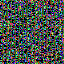

In [40]:
from PIL import Image
sampled_images = diffusion.sample(batch_size=100)
arr = sampled_images[0].cpu().numpy()
mode = "RGB" if channels == 3 else "L"
if mode == "RGB":
  arr = arr.transpose(1, 2, 0)
Image.fromarray(arr, mode=mode)